# Geographical Origins of Music

In [1]:
import autograd.numpy as np
from autograd import grad
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## Loading the data

In [2]:
# Load the Geographical Origins of Music dataset
data = pd.read_table('Geographical Original of Music/default_plus_chromatic_features_1059_tracks.txt', sep=',', header=None)
data.rename(columns={116:'Latitude', 117:'Longitude'}, inplace=True)

We split the dataset in two : a train dataset with 80% of the data, and a test data set with the remaining 20% of the data.

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-2], data.iloc[:,-2:], test_size=0.20, random_state=42)

Let us plot the geographical repartition in the train and test datasets.

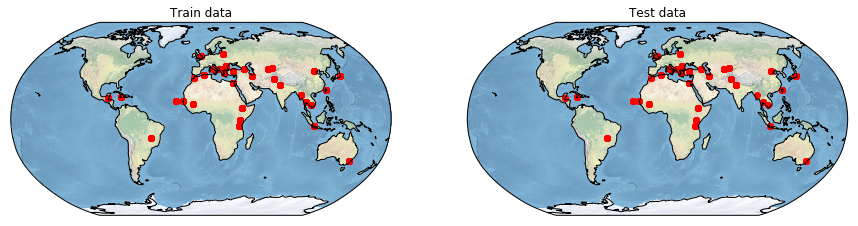

In [4]:
fig = plt.figure(figsize=(15, 10))

# Train data
ax = fig.add_subplot(1, 2, 1, projection=ccrs.Robinson())

ax.stock_img()
ax.coastlines()

ax.set_title('Train data')
ax.scatter(y_train['Longitude'], y_train['Latitude'], c='r', transform=ccrs.Geodetic())

# Test data
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.Robinson())

ax2.stock_img()
ax2.coastlines()

ax2.set_title('Test data')
ax2.scatter(y_test['Longitude'], y_test['Latitude'], c='r', transform=ccrs.Geodetic())

plt.show()

## Prediction of Longitude/Latitude with a 2-layer neural network

In [5]:
# Size of the neural network layers
size_features = X_train.shape[1]
size_hidden_layer = 20
size_prediction = 2

In [6]:
# Compute the min and max of the Latitudes and Longitudes in the train dataset
# This will be useful for rescaling the output of the neural network
min_latitude = y_train['Latitude'].min()
max_latitude = y_train['Latitude'].max()
min_longitude = y_train['Longitude'].min()
max_longitude = y_train['Longitude'].max()

In [7]:
# Define the targets and inputs of the neural network
targets = np.array(y_train)
inputs = np.array(X_train.T)

In [8]:
def network(inputs, A1, A2, b1, b2, sgd=False):
    '''Return the predicted value for features x with a 2-layer neural network of parameters A1 and A2 and biases b1 and b2.'''
    assert inputs.shape[0] == A1.shape[1]
    assert A2.shape == (2, A1.shape[0])
    if sgd: # If only one data is to be computed
        [latitude, longitude] = b2 + np.tanh(np.dot(A2, b1 + np.tanh(np.dot(A1, inputs))))
    else: # If the network has to compute several outputs 
        [latitude, longitude] = np.repeat(b2, inputs.shape[1]).reshape(b2.shape[0],-1) + np.tanh(np.dot(A2, np.repeat(b1, inputs.shape[1]).reshape(b1.shape[0],-1) + np.tanh(np.dot(A1, inputs))))
    latitude = min_latitude + 0.5*(latitude+1)*(max_latitude - min_latitude)
    longitude = min_longitude + 0.5*(longitude+1)*(max_longitude - min_longitude)
    return np.array([latitude, longitude]).T

In [9]:
def loss(y_pred, y_true):
    '''Return the arc-cosine distance on the Earth between y_pred and y_true.'''
    latitude_pred, longitude_pred = y_pred*np.pi/180.
    latitude_true, longitude_true = y_true*np.pi/180.
    delta_latitude = latitude_pred - latitude_true
    delta_longitude = longitude_pred - longitude_true
    R = 6371
    return 2*R*np.arcsin(np.sqrt( np.sin(0.5*delta_latitude)**2 + np.cos(latitude_pred)*np.cos(latitude_true)*np.sin(0.5*delta_longitude)**2 ))

In [10]:
def objective(weights):
    '''Compute the objective to be minimized by the network using a gradient descent approach.'''
    A1, A2, b1, b2 = weights
    pred = network(inputs, A1, A2, b1, b2)
    return np.sum([loss(pred[i], targets[i]) for i in range(inputs.shape[1])])/inputs.shape[1]

In [11]:
def objective_sgd(weights):
    '''Compute the objective to be minimized by the network using a stochastic gradient descent approach.'''
    A1, A2, b1, b2 = weights
    i = np.random.randint(inputs.shape[1])
    pred = network(inputs[:,i], A1, A2, b1, b2, sgd=True)
    return loss(pred, targets[i])

In [12]:
def objective_test(weights):
    '''Compute the objective for the test dataset.'''
    A1, A2, b1, b2 = weights
    pred = network(X_test.T, A1, A2, b1, b2)
    return np.sum([loss(pred[i], y_test.iloc[i,:]) for i in range(X_test.shape[0])])/X_test.shape[0]

### Gradient Descent

We fist use a Gradient Descent approach to minimize the loss function

In [13]:
np.random.seed(0)

epochs = 40 # Number of epochs to be ran by the Gradient Descent algorithm
learning_rate = 0.00005

# Initialize the weights and biases of the network
A1 = np.random.randn(size_hidden_layer, size_features)
A2 = np.random.randn(size_prediction, size_hidden_layer)
b1 = np.random.randn(size_hidden_layer)
b2 = np.random.randn(size_prediction)

# Compute the gradient of the objective
grad_loss = grad(objective)

print('Iteration', '|', 'Train loss', '|', 'Test loss')
for t in range(epochs):
    print(t, '        | ', int(objective([A1,A2,b1,b2])), 'km   | ', int(objective_test([A1,A2,b1,b2])), 'km')
    # Compute the gradients
    grad_A1, grad_A2, grad_b1, grad_b2 = grad_loss([A1, A2, b1, b2])
    
    # Update the weights and biases
    A1 = A1 - learning_rate * grad_A1
    A2 = A2 - learning_rate * grad_A2
    b1 = b1 - learning_rate * grad_b1
    b2 = b2 - learning_rate * grad_b2

# Save the weights and biases
A1_GD, A2_GD, b1_GD, b2_GD = A1, A2, b1, b2

Iteration | Train loss | Test loss
0         |  10063 km   |  10366 km
1         |  8983 km   |  9340 km
2         |  7898 km   |  8199 km
3         |  6997 km   |  7207 km
4         |  6484 km   |  6513 km
5         |  6084 km   |  6049 km
6         |  5764 km   |  5698 km
7         |  5601 km   |  5444 km
8         |  5481 km   |  5276 km
9         |  5370 km   |  5147 km
10         |  5258 km   |  5016 km
11         |  5157 km   |  4898 km
12         |  5064 km   |  4780 km
13         |  4980 km   |  4667 km
14         |  4906 km   |  4560 km
15         |  4844 km   |  4475 km
16         |  4789 km   |  4403 km
17         |  4738 km   |  4341 km
18         |  4690 km   |  4287 km
19         |  4645 km   |  4239 km
20         |  4606 km   |  4201 km
21         |  4577 km   |  4174 km
22         |  4555 km   |  4154 km
23         |  4540 km   |  4138 km
24         |  4537 km   |  4157 km
25         |  4518 km   |  4116 km
26         |  4520 km   |  4142 km
27         |  4502 km   |  4

### Stochastic Gradient Descent

As we observe that the convergence of the Gradient Descent approach is slow, we also try a Stochastic Gradient Descent Approach. Since the objective is non convex, a stochastic approach will more likely avoid being stuck in local minima.
We use a decaying learning rate in $1/\sqrt{t}$ where $t$ is the number of iterations, and a Polyak-Ruppert averaging. This will always be the case in the rest of this notebook.

Since the Stochastic Gradient Descent approach seems to converge way faster than the Gradient Descent approach in this case, we do not use the sae number of epochs : the SGD algorithm will use less data in this very application.

In [14]:
np.random.seed(0)

epochs = 5 # Number of passes over the data
learning_rate = 0.00005

# Initialize the weights and biases of the network
A1 = np.random.randn(size_hidden_layer, size_features)
A2 = np.random.randn(size_prediction, size_hidden_layer)
b1 = np.random.randn(size_hidden_layer)
b2 = np.random.randn(size_prediction)

# Initialize the averaged weights and biases of the network
A1_moy = np.copy(A1)
A2_moy = np.copy(A2)
b1_moy = np.copy(b1)
b2_moy = np.copy(b2)

# Compute the gradient of the objective
grad_loss = grad(objective_sgd)

print('Number of passes', '|', 'Train loss', '|', 'Test loss')
for t in range(epochs*X_train.shape[0]):
    if t % X_train.shape[0] == 0:
        print(t/X_train.shape[0], '             | ', int(objective([A1_moy,A2_moy,b1_moy,b2_moy])), 'km   | ', int(objective_test([A1_moy,A2_moy,b1_moy,b2_moy])), 'km')
    # Compute the gradients
    grad_A1, grad_A2, grad_b1, grad_b2 = grad_loss([A1, A2, b1, b2])
    
    # Update the weights and biases
    A1 = A1 - learning_rate * (1./np.sqrt(t+1)) * grad_A1
    A2 = A2 - learning_rate * (1./np.sqrt(t+1)) * grad_A2
    b1 = b1 - learning_rate * (1./np.sqrt(t+1))* grad_b1
    b2 = b2 - learning_rate * (1./np.sqrt(t+1))* grad_b2
    
    # Compute the averaged weights and biases
    A1_moy = (t*A1_moy + A1)/(t+1)
    A2_moy = (t*A2_moy + A2)/(t+1)
    b1_moy = (t*b1_moy + b1)/(t+1)
    b2_moy = (t*b2_moy + b2)/(t+1)

# Save the weights and biases
A1_SGD, A2_SGD, b1_SGD, b2_SGD = A1_moy, A2_moy, b1_moy, b2_moy

Number of passes | Train loss | Test loss
0.0              |  10063 km   |  10366 km
1.0              |  4425 km   |  4076 km
2.0              |  4389 km   |  4048 km
3.0              |  4386 km   |  4045 km
4.0              |  4384 km   |  4037 km


### Results

Let us plot some random test data, and the predicted values for the GD approach and the SGD approach

We can see that in both cases, the network fails to predict correctly the origin of a music piece. The train loss, as well as the test loss, are approximately of 4000km, which is clearly not precise enough. In particular, the network seems to always predict points at the center of the map (Europe/North Africa/Middle East), since this is a good strategy for musics coming from this area (predicting Europe instead of North Africa is cheap in terms of the arc-cosine loss), and not too costly for musics coming from South America/East Asia/Oceania.

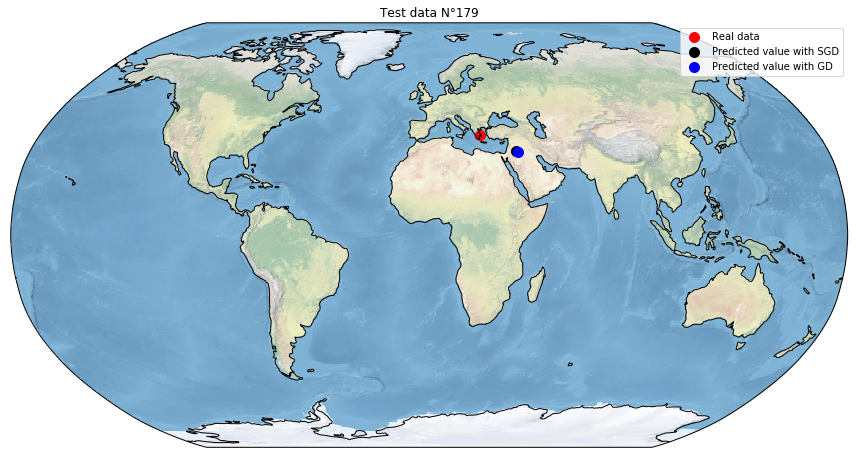

In [15]:
i = np.random.randint(X_test.shape[0])

pred_SGD = network(X_test.iloc[i,:].T, A1_SGD, A2_SGD, b1_SGD, b2_SGD, True)
pred_GD = network(X_test.iloc[i,:].T, A1_GD, A2_GD, b1_GD, b2_GD, True)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.stock_img()
ax.coastlines()

ax.scatter(y_test['Longitude'].iloc[i], y_test['Latitude'].iloc[i], c='r', s=100, transform=ccrs.Geodetic(), label='Real data')
ax.scatter([pred_SGD[0]], [pred_SGD[1]], c='k', transform=ccrs.Geodetic(), s=100, label='Predicted value with SGD')
ax.scatter([pred_GD[0]], [pred_GD[1]], c='b', transform=ccrs.Geodetic(), s=100, label='Predicted value with GD')

ax.set_title('Test data N°'+str(i))

plt.legend()
plt.show()

## Predicting a heatmap

In [16]:
# Load the music data
data = pd.read_table('Geographical Original of Music/default_plus_chromatic_features_1059_tracks.txt', sep=',', header=None)
data.drop(data.columns[-2:], axis=1, inplace=True)
data = np.array(data)

In [17]:
# Load the geographical maps
maps = np.array(pd.read_table('heatmap.txt', sep='   ', header=None, engine='python'))

In [18]:
# Concatenate music data and geographical maps
data = np.concatenate([data, maps], axis=1)

In [19]:
# Split the dataset in two : train dataset (80% of the data) and a test dataset (the 20% remaining)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data[:,:-400], data[:,-400:], test_size=0.20, random_state=42)

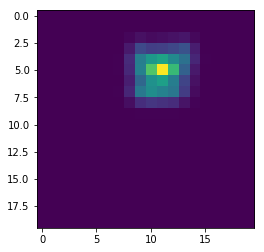

In [20]:
# Plot a random data
i = np.random.randint(y_train.shape[0])
plt.imshow(y_train[i].reshape(20,20))
plt.show()

### Model

In [21]:
# Size of the neural network layers
size_features = X_train.shape[1]
size_hidden_layer = 100
size_prediction = 400

In [22]:
# Define the targets and inputs of the neural network
targets = np.array(y_train)
inputs = np.array(X_train.T)

In [23]:
def softmax(x):
    '''Return the softmax of vector x.'''
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [24]:
def network(inputs, A1, A2, b1, b2, sgd=False):
    '''Return the predicted value for features x with a 2-layer neural network of weights A1 and A2 and biases b1 and b2.'''
    assert inputs.shape[0] == A1.shape[1]
    assert A2.shape == (400, A1.shape[0])
    if sgd: # If there is only one data to be predicted
        return softmax(b2 + np.dot(A2, b1 + np.tanh(np.dot(A1, inputs))))
    else: # If there is several data to be passed to the network
        return softmax(np.repeat(b2, inputs.shape[1]).reshape(b2.shape[0],-1) + np.dot(A2, np.repeat(b1, inputs.shape[1]).reshape(b1.shape[0],-1) + np.tanh(np.dot(A1, inputs))))

### Gradient Descent with a KL loss

In [25]:
def entropy(p, q):
    '''Return the entropy of p wrt q.'''
    tol = 0.001
    assert p.shape[0] == q.shape[0]
    assert np.prod(q>0) == 1
    return -np.sum(p*np.log(q+tol))
    
def objective_KL(weights):
    '''Compute the objective to be minimized with a KL (entropy) loss and a gradient descent approach.'''
    A1, A2, b1, b2 = weights
    pred = network(inputs, A1, A2, b1, b2)
    return np.sum([entropy(targets[i], pred[:,i]) for i in range(inputs.shape[1])])/inputs.shape[1]

def objective_KL_sgd(weights):
    '''Compute the objective to be minimized with a KL (entropy) loss and a stochastic gradient descent approach.'''
    A1, A2, b1, b2 = weights
    i = np.random.randint(inputs.shape[1])
    pred = network(inputs[:,i], A1, A2, b1, b2, True)
    return entropy(targets[i], pred)

def objective_KL_test(weights):
    '''Compute the objective with a KL (entropy) loss for the test dataset.'''
    A1, A2, b1, b2 = weights
    pred = network(X_test.T, A1, A2, b1, b2)
    return np.sum([entropy(y_test[i], pred[:,i]) for i in range(X_test.shape[1])])/X_test.shape[1]

In [26]:
np.random.seed(0)

epochs = 30 # Number of epochs to be run
learning_rate = 8.

# Initialize the network's weigths and biases
A1 = 0.01*np.random.randn(size_hidden_layer, size_features)
A2 = 0.01*np.random.randn(size_prediction, size_hidden_layer)
b1 = 0.01*np.random.randn(size_hidden_layer)
b2 = 0.01*np.random.randn(size_prediction)

In [27]:
# Compute the gradient of the objective
grad_loss = grad(objective_KL)

print('Iteration', '|', 'Train loss', '         |', 'Test loss')
for t in range(epochs):
    print(t, '        | ', objective_KL([A1,A2,b1,b2]), ' | ', objective_KL_test([A1,A2,b1,b2]))
    
    # Compute the gradients of the parameters
    grad_A1, grad_A2, grad_b1, grad_b2 = grad_loss([A1, A2,b1,b2])
    
    # Run the descent step
    A1 = A1 - learning_rate * grad_A1
    A2 = A2 - learning_rate * grad_A2
    b1 = b1 - learning_rate * grad_b1
    b2 = b2 - learning_rate * grad_b2

# Save the parameters
A1_KL_GD, A2_KL_GD, b1_KL_GD, b2_KL_GD = A1, A2, b1, b2

Iteration | Train loss          | Test loss
0         |  5.6551632657835365  |  5.65470831564745
1         |  5.630877889617737  |  5.626863444749619
2         |  5.599330250343686  |  5.590879355104401
3         |  5.547054108220121  |  5.533054102129101
4         |  5.46865296034869  |  5.447918815853733
5         |  5.3700967013703504  |  5.342421311128577
6         |  5.2599012285001985  |  5.21952325822918
7         |  5.1645327092365605  |  5.156378413144039
8         |  5.072706488982125  |  5.072465366304133
9         |  5.010363275728492  |  5.034426116655362
10         |  4.98258603773195  |  5.027576691184348
11         |  4.876940918407619  |  4.915351063121796
12         |  4.81871281999641  |  4.8810994940534815
13         |  4.790950422602163  |  4.828881266481305
14         |  4.824723472806753  |  4.915764794255147
15         |  4.727658535711287  |  4.755201976932438
16         |  4.7429841159561885  |  4.852178731523821
17         |  4.76291514233051  |  4.7920799540

### Stochastic Gradient Descent with a KL loss

In [28]:
np.random.seed(0)

epochs = 30 # Number of passes over the data
learning_rate = 8.

# Initialize the network's parameters
A1 = 0.01*np.random.randn(size_hidden_layer, size_features)
A2 = 0.01*np.random.randn(size_prediction, size_hidden_layer)
b1 = 0.01*np.random.randn(size_hidden_layer)
b2 = 0.01*np.random.randn(size_prediction)

# Initialize the averaged parameters
A1_moy = np.copy(A1)
A2_moy = np.copy(A2)
b1_moy = np.copy(b1)
b2_moy = np.copy(b2)

In [29]:
# Compute the gradient of the SGD objective
grad_loss = grad(objective_KL_sgd)

print('Number of passes', '|', 'Train loss', '         |', 'Test loss')
for t in range(epochs*X_train.shape[0]):
    if t % X_train.shape[0] == 0:
        print(t/X_train.shape[0], '             | ', objective_KL([A1_moy,A2_moy,b1_moy,b2_moy]), ' | ', objective_KL_test([A1_moy,A2_moy,b1_moy,b2_moy]))
    
    # Compute the gradients of the parameters
    grad_A1, grad_A2, grad_b1, grad_b2 = grad_loss([A1, A2,b1,b2])
    
    # Run the descent step
    A1 = A1 - learning_rate * (1./np.sqrt(t+1)) * grad_A1
    A2 = A2 - learning_rate * (1./np.sqrt(t+1)) * grad_A2
    b1 = b1 - learning_rate * (1./np.sqrt(t+1)) * grad_b1
    b2 = b2 - learning_rate * (1./np.sqrt(t+1)) * grad_b2
    
    # Run the averaging step
    A1_moy = (t*A1_moy + A1)/(t+1)
    A2_moy = (t*A2_moy + A2)/(t+1)
    b1_moy = (t*b1_moy + b1)/(t+1)
    b2_moy = (t*b2_moy + b2)/(t+1)
    
# Save the parameters
A1_KL_SGD, A2_KL_SGD, b1_KL_SGD, b2_KL_SGD = A1_moy, A2_moy, b1_moy, b2_moy

Number of passes | Train loss          | Test loss
0.0              |  5.6551632657835365  |  5.65470831564745
1.0              |  5.273692911848821  |  5.28900996133799
2.0              |  4.9576707280328405  |  5.042265941673636
3.0              |  4.7633013876721435  |  4.896078059608716
4.0              |  4.622604740041685  |  4.8051550156899525
5.0              |  4.508290165652737  |  4.739514618424492
6.0              |  4.410895066920947  |  4.696790758794484
7.0              |  4.329836483742593  |  4.666397602848995
8.0              |  4.260651822008017  |  4.645913525096381
9.0              |  4.19853197651668  |  4.627852131188153
10.0              |  4.143785888928725  |  4.614642969614493
11.0              |  4.094026118671682  |  4.6045192191046285
12.0              |  4.0489799641030775  |  4.596314006562795
13.0              |  4.008193602751818  |  4.589456647473691
14.0              |  3.9708365505487873  |  4.585583234718504
15.0              |  3.93591837226512  |

### Results

Let us plot some random test data, and the predicted values for the GD approach and the SGD approach (for the KL/entropy loss). As the test losses show, the Stochastic Gradient Approach leads to slightly better predictions than the GD approach.

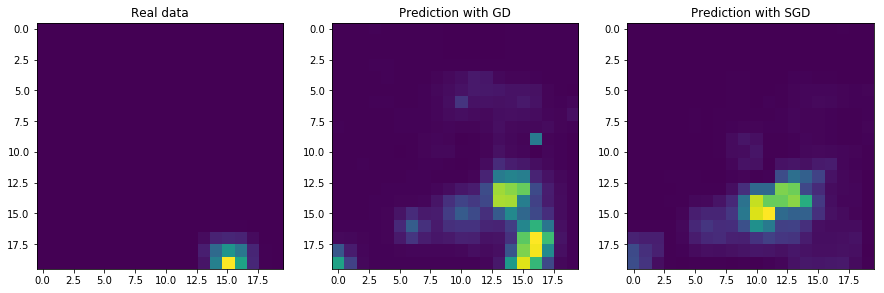

In [30]:
i = np.random.randint(X_test.shape[0])

pred_GD = network(X_test[i], A1_KL_GD, A2_KL_GD, b1_KL_GD, b2_KL_GD, True)
pred_SGD = network(X_test[i], A1_KL_SGD, A2_KL_SGD, b1_KL_SGD, b2_KL_SGD, True)

fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(1, 3, 1)
ax.imshow(y_test[i].reshape(20,20))
ax.set_title('Real data')

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(pred_GD.reshape(20,20))
ax2.set_title('Prediction with GD')

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(pred_SGD.reshape(20,20))
ax3.set_title('Prediction with SGD')

plt.show()

### Stochastic Gradient Descent with a 1-Wasserstein loss

Because it is too time consuming, we do not consider training the network with a Gradient Descent approach. We only consider Stochastic Gradient Descent.

In [31]:
from ot.dr import sinkhorn

reg = 1. # Regularization in Sinkhorn algorithm
k = 5 # Number of iterations in Sinkhorn algorithm

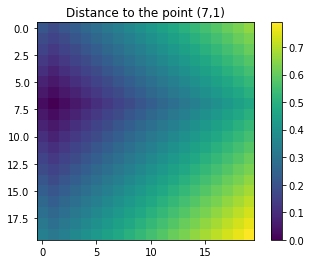

In [32]:
# Compute the metric M on the 20x20 grid
M = np.zeros((400,400))
for i in range(20):
    for j in range(20):
        for k in range(20):
            for l in range(20):
                M[( 20*i+j ), ( 20*k+l )] = abs(i-k) + abs(j-l) #Distance between (i,j) and (k,l)
M /= np.max(M)

i = np.random.randint(20)
j = np.random.randint(20)
plt.imshow(M.reshape(20,20,20,20)[i,j])
plt.colorbar()
plt.title('Distance to the point ('+str(i)+','+str(j)+')')
plt.show()

In [33]:
def objective(weights):
    '''Compute the objective to be minimized by a gradient descent approach with a 1-Wasserstein loss.'''
    A1, A2, b1, b2 = weights
    pred = network(inputs, A1, A2, b1, b2)
    return np.sum([np.sum(M*sinkhorn(targets[i], pred[:,i], M, reg, k)) for i in range(inputs.shape[1])])/inputs.shape[1]

def objective_sgd(weights):
    '''Compute the objective to be minimized by a stochastic gradient descent approach with a 1-Wasserstein loss.'''
    A1, A2, b1, b2 = weights
    i = np.random.randint(inputs.shape[1])
    pred = network(inputs[:,i], A1, A2, b1, b2, True)
    return np.sum(M*sinkhorn(targets[i], pred, M, reg, k))

def objective_test(weights):
    '''Compute the objective with a 1-Wasserstein loss for the test dataset.'''
    A1, A2, b1, b2 = weights
    pred = network(X_test.T, A1, A2, b1, b2)
    return np.sum([np.sum(M*sinkhorn(y_test[i], pred[:,i], M, reg, k)) for i in range(X_test.shape[1])])/X_test.shape[1]

In [34]:
np.random.seed(0)

epochs = 3 # Number of passes over the data
learning_rate = 1.

# Initialize the network's parameters
A1 = np.random.randn(size_hidden_layer, size_features)
A2 = np.random.randn(size_prediction, size_hidden_layer)
b1 = np.random.randn(size_hidden_layer)
b2 = np.random.randn(size_prediction)

# Initialize the averaged parameters
A1_moy = np.copy(A1)
A2_moy = np.copy(A2)
b1_moy = np.copy(b1)
b2_moy = np.copy(b2)

__BEWARE : the next chunk can be very time consuming__ due to the computation of the gradient of the Sinkhorn algorithm.

In [35]:
# Compute the gradient of the SGD objective
grad_loss = grad(objective_sgd)

print('Number of passes', '|', 'Train loss', '           |', 'Test loss')
for t in range(epochs*X_train.shape[0]):
    if t % X_train.shape[0] == 0:
        print(t/X_train.shape[0], '             | ', objective([A1_moy,A2_moy, b1_moy, b2_moy]), ' | ', objective_test([A1_moy,A2_moy, b1_moy, b2_moy]))
        
    # Compute the gradients of the parameters
    grad_A1, grad_A2, grad_b1, grad_b2 = grad_loss([A1, A2, b1, b2])
    
    # Run the descent step
    A1 = A1 - (learning_rate/np.sqrt(t+1)) * grad_A1
    A2 = A2 - (learning_rate/np.sqrt(t+1)) * grad_A2
    b1 = b1 - learning_rate * (1./np.sqrt(t+1)) * grad_b1
    b2 = b2 - learning_rate * (1./np.sqrt(t+1)) * grad_b2
    
    # Run the averaging step
    A1_moy = (t*A1_moy + A1)/(t+1)
    A2_moy = (t*A2_moy + A2)/(t+1)
    b1_moy = (t*b1_moy + b1)/(t+1)
    b2_moy = (t*b2_moy + b2)/(t+1)

# Save the parameters
A1_W_SGD, A2_W_SGD, b1_W_SGD, b2_W_SGD = A1_moy, A2_moy, b1_moy, b2_moy

Number of passes | Train loss            | Test loss
0.0              |  0.32154217773970933  |  0.3440792211010879
1.0              |  0.22679983392909575  |  0.22561626086425393
2.0              |  0.22342262119969836  |  0.22273587608913897


### Results

Let us compare the predictions of the network trained with a 1-Wasserstein loss and with a KL loss.

In [40]:
print('Wasserstein test loss for the Wasserstein network :',objective_test([A1_W_SGD, A2_W_SGD, b1_W_SGD, b2_W_SGD]))
print('Wasserstein test loss for the KL network :', objective_test([A1_KL_SGD, A2_KL_SGD, b1_KL_SGD, b2_KL_SGD]))

Wasserstein test loss for the Wasserstein network : 0.22172838631909533
Wasserstein test loss for the KL network : 0.18584439158764254


The Wasserstein-trained network leads to a larger Wasserstein loss than the KL-trained network. This means that training a network with a Wasserstein loss can be quite tricky.

Visually, we can see that the 1-Wasserstein loss network often predict a Dirac measure, while the KL network predicts more spatially diverse measure on the grid. __For this particular example and network architechture, the KL loss leads to both numerically and visually better results.__

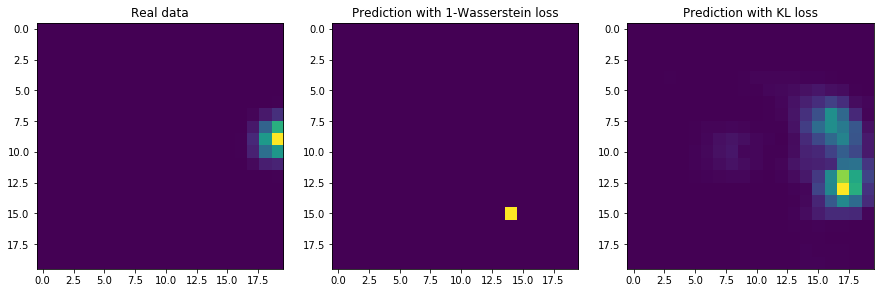

In [42]:
i = np.random.randint(X_test.shape[0])

pred_W = network(X_test[i], A1_W_SGD, A2_W_SGD, b1_W_SGD, b2_W_SGD, True)
pred_KL = network(X_test[i], A1_KL_SGD, A2_KL_SGD, b1_KL_SGD, b2_KL_SGD, True)

fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(1, 3, 1)
ax.imshow(y_test[i].reshape(20,20))
ax.set_title('Real data')

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(pred_W.reshape(20,20))
ax2.set_title('Prediction with 1-Wasserstein loss')

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(pred_KL.reshape(20,20))
ax3.set_title('Prediction with KL loss')

plt.show()